## Maschinelles Lernen SoSe 2023


### Praktikum 9

K-Means Clustering: Clustern Sie Pixel in Farbbildern und segmentieren Sie so visuell Bilder aus diesem Bereich. Die folgenden Experimente können Sie mit beliebigen Bildern durchführen oder Beispiel-Bilder aus dem 101-Datensatz verwenden verwenden. 

Im FELIX-Ordner von praktikum09 befinden sich die Bilder sunflower und baloon.


Betrachten Sie die Pixel in einem beliebigen RGB-Bild als unabhängige Beobachtungen. Jeder der Pixel ist durch seine Farbe (3D-Vektor: R,G,B oder H,S,V) charakterisiert. Die Farben im Bild sollen nun auf eine vorgegebene Anzahl reduziert werden (z.B. 4). Dabei sollen ähnliche Farben im Merkmalsraum zusammengefasst werden. Alle einem Cluster zugehörige Pixel sollen nun im Bild durch den Clustermittelwert ersetzt werden.

In [1]:
import numpy as np
np.seterr(all='ignore') # to suppress errors in color conversion fkts
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn import cluster
from sklearn.cluster import KMeans
from skimage import io
from sklearn.preprocessing import MinMaxScaler
import skimage.io
from skimage.color import rgb2hsv, hsv2rgb
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import pairwise_distances_argmin
import matplotlib.pyplot as plt
from skimage import data

Lesen Sie zunächst ein beliebiges Bild ein. Sie können z.B. sunflower oder baloon verwenden:

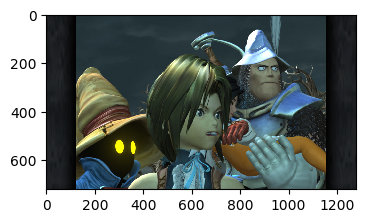

In [2]:
data_raw = skimage.io.imread("FFIX.jpg")
data = np.array(data_raw)
plt.figure(figsize=(4, 4))
plt.imshow(data, interpolation='nearest')

Normalisieren Sie die RGB-Werte entweder auf Werte zwischen 0-1 oder wandeln Sie das Bild in HSV um (dann sind die Werte auch zwischen 0 und 1...).

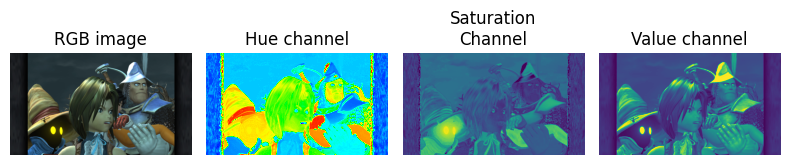

In [3]:
rgb_img = data
#print(rgb_img)

hsv_img = rgb2hsv(rgb_img)
hue_img = hsv_img[:, :, 0]
sat_img = hsv_img[:,:,1]
value_img = hsv_img[:, :, 2]

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(8, 2))

ax0.imshow(rgb_img)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(sat_img)
ax2.set_title('Saturation\nChannel')
ax2.axis('off')
ax3.imshow(value_img)
ax3.set_title("Value channel")
ax3.axis('off')

fig.tight_layout()

Dann müssen die Pixel des Bildes wieder in eine Matrix gebracht werden: (numPixes, 3) 

In [4]:
#227,227,3 -> (227*227,3)
print(hsv_img.shape)
hsv_matrix = hsv_img.reshape(720*1280,3)
#print("resize: \n", hsv_matrix)

(720, 1280, 3)


Nun kann das Clusterig stattfinden:

K-Means:
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn-cluster-kmeans

Gaussian Mixture Models:
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture


In [5]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(hsv_matrix)
print(kmeans)
#print("labels: ", kmeans.labels_)

labels = kmeans.predict(hsv_matrix)

#print("\ncluster_centers:\n", kmeans.cluster_centers_)

gm = GaussianMixture(n_components=2, random_state=0).fit(hsv_matrix)
labels_gm = gm.predict(hsv_matrix)
print(gm)

KMeans(n_clusters=2, n_init='auto', random_state=0)
GaussianMixture(n_components=2, random_state=0)


Weisen Sie nun den Pixeln die Klassenlabel zu, und ersetzen Sie die Farbe des Pixels durch das jeweilige Klassenzentrum (=Mittelwert der Pixel im Cluster). 

In [6]:
test_random = shuffle(hsv_matrix, random_state=0, n_samples=64)

hsv_to_rgb_matrix = hsv2rgb(hsv_matrix)
labels_random = pairwise_distances_argmin(test_random, hsv_to_rgb_matrix, axis=0)
labels_random_gm = pairwise_distances_argmin(test_random, hsv_to_rgb_matrix, axis=0)


w, h, d = original_shape = tuple(rgb_img.shape)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)


Zeigen Sie nun das Bild mit den Pixelclustern an:

(-0.5, 1279.5, 719.5, -0.5)

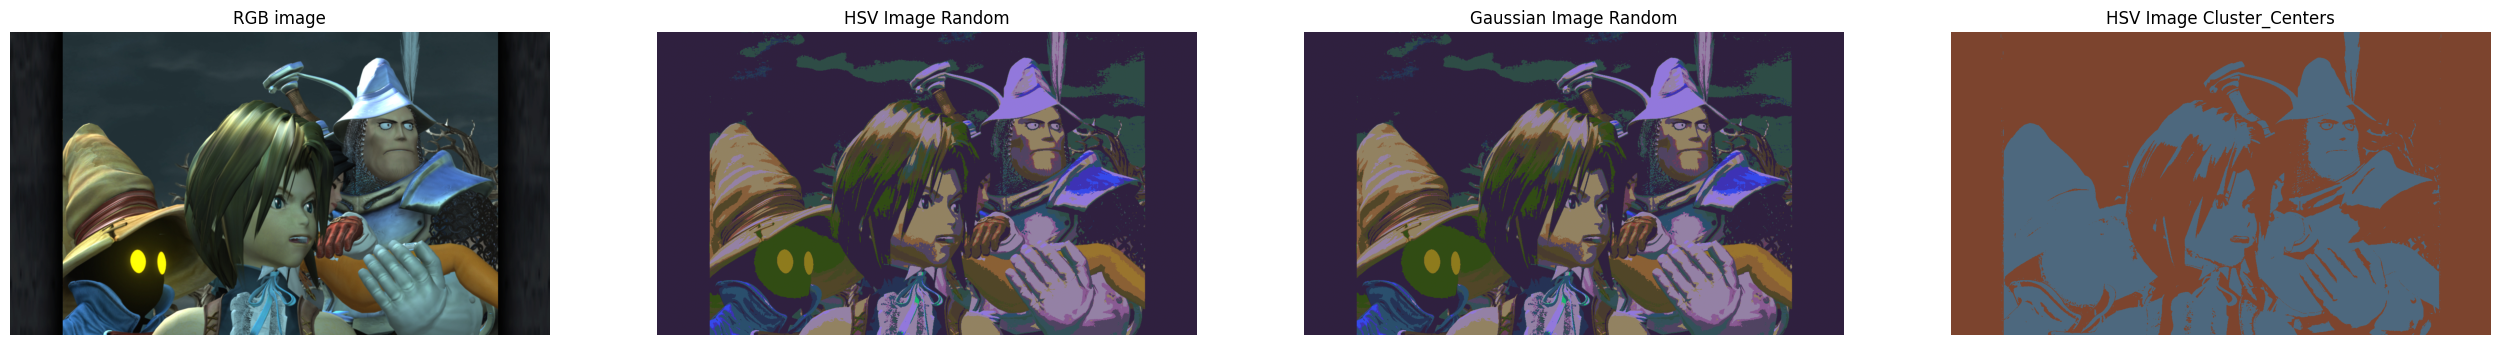

In [7]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(32, 32))

ax0.imshow(rgb_img)
ax0.set_title("RGB image")
ax0.axis('off')


ax1.imshow(recreate_image(test_random, labels_random, w, h))
ax1.set_title("HSV Image Random")
ax1.axis('off')

ax2.imshow(recreate_image(test_random, labels_random_gm, w, h))
ax2.set_title("Gaussian Image Random")
ax2.axis('off')

ax3.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))
ax3.set_title("HSV Image Cluster_Centers")
ax3.axis('off')


# Beantworten Sie folgende Fragen:
    
 ## Für welche Art von Bildern funktioniert die Segmentierung durch Clustering gut?
 Am besten für Bilder mit wenig Farbübergangen. So ist es dem Clustering einfacher, die verschiedene Farben einzuteilen.
 Übergänge verwirrt das Clustering nur und Artefakte enstehen.
 
 ## Erhalten Sie immer die gleichen Ergebnisse, wenn Sie die Algorithmen laufen lassen? Wenn nein, woran liegt das?
 Bei dem KMeans werden die Nummerischen Werte immer ein wenig anders.
 ## Was passiert wenn man eine zu große/kleine Anzahl an Clustern angibt?
 Wenn Sie zu klein ist, hat man zu wenige Cluster. Somit gibt es harte Übergänge. Bei zu vielen entsteht Overfitting
 ## Wie findet man die optimale Anzahl an Clustern?
 Mit dem Elbow Methode. So lässt sich erschließen, ab wann die Perfekte Anzahl von Clustern funktioniert. Hier ist dann der Wert, der im "Ellenbogen" liegt, der bestmöglichste.